
## About MovieLens Dataset
Context

The datasets describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. 


### Content

No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in six files.

tag.csv that contains tags applied to movies by users:

    userId

    movieId

    tag

    timestamp

rating.csv that contains ratings of movies by users:

    userId

    movieId

    rating

    timestamp

movie.csv that contains movie information:

    movieId

    title

    genres

link.csv that contains identifiers that can be used to link to other sources:

    movieId

    imdbId

    tmbdId

genome_scores.csv that contains movie-tag relevance data:

    movieId

    tagId

    relevance

genome_tags.csv that contains tag descriptions:

    tagId

    tag

### Overview
Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.




In [1]:
data_dir = "../data/raw/movielens-20m-dataset/"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import plotly.express as px

# Avisos
import warnings
warnings.filterwarnings('ignore')

# Ajustes no pandas
pd.set_option('display.max_rows', 100 ) # Linhas
pd.set_option('display.max_columns', 50 ) # Colunas
 
# Ajustes no matplot
plt.rcParams['figure.figsize'] = (15, 6)  # Tamanho do gráfico
plt.style.use('seaborn-darkgrid') # Estilo do gráfico

In [3]:
from fileinput import filename


def generate_wordcloud(df, column, name=[], save=False):
    comment_words = ''
    # iterate through the csv file
    for val in df[column]:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "

    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    if save:
        plt.savefig(name)
    plt.show()

# 1. tags

Tags são marcados especificados por um usuário para um filme.

In [4]:
tag_df = pd.read_csv(data_dir + 'tag.csv')
tag_df.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [5]:
tags = tag_df.tag.unique()
tags.shape

(38644,)

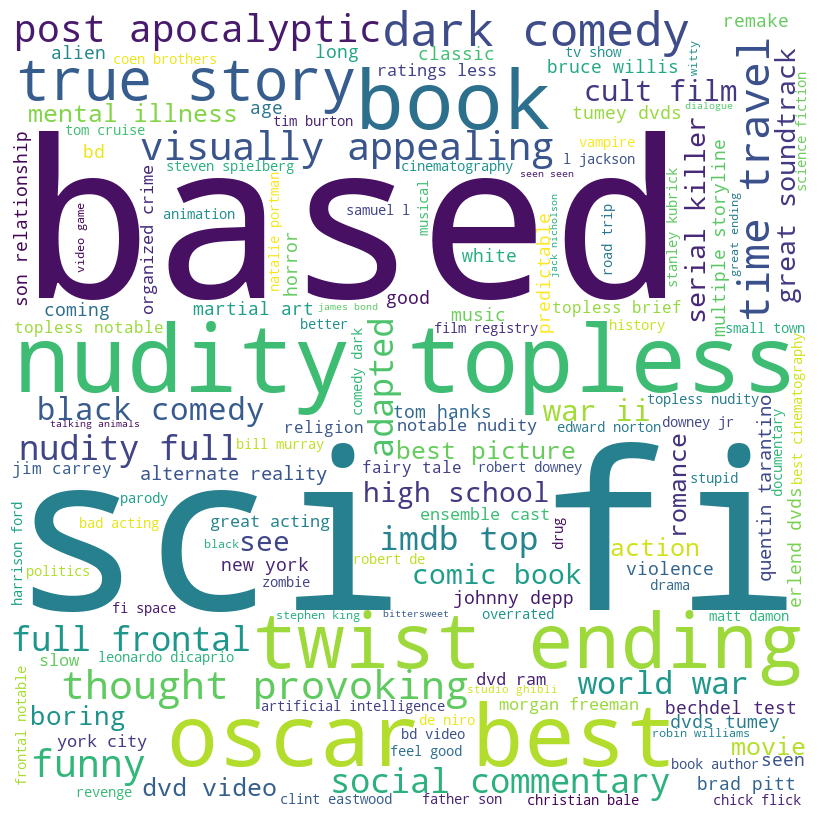

In [6]:
generate_wordcloud(tag_df, 'tag', name='tags_user.png', save=True)
plt.show()
# plt.savefig('wordcloud.png', dpi=300)

# 2. genome tags and scores

The tag genome is a data structure that contains tag relevance scores for movies. The structure is a dense matrix: each movie in the genome has a value for every tag in the genome.

As described in the article "The Tag Genome: Encoding Community Knowledge to Support Novel Interaction", the tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

In [7]:
genome_tags_df  = pd.read_csv(data_dir + 'genome_tags.csv')
genome_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [8]:
genome_tags_df.shape

(1128, 2)

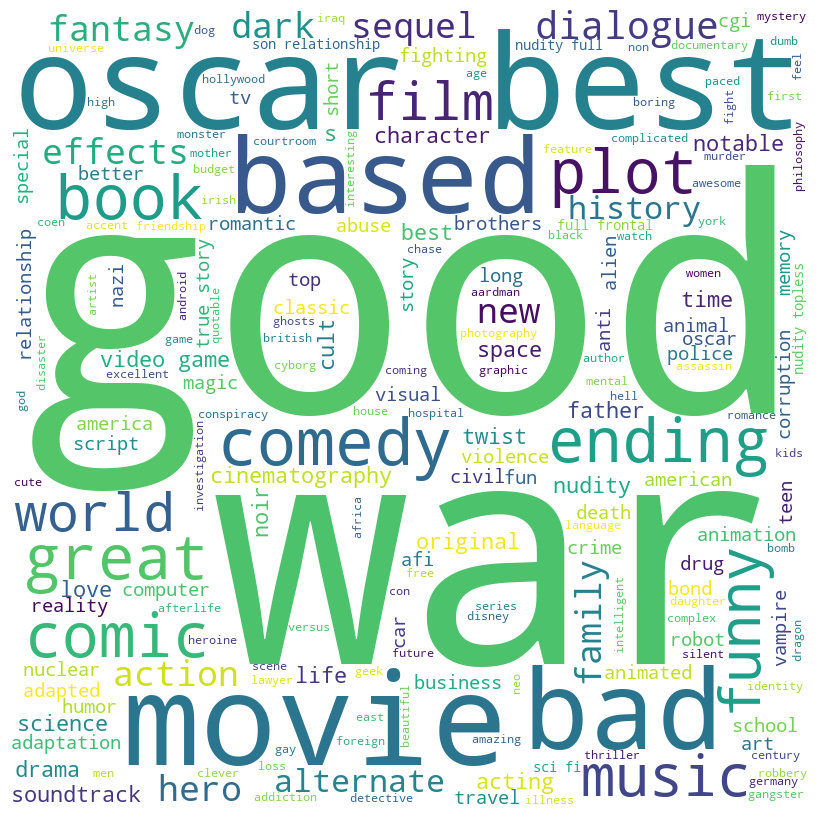

In [9]:
generate_wordcloud(genome_tags_df, 'tag')

Aqui, temos uma relação de relevância entre as tags e os filmes, mas não de um usuário específico. É como se fosse uma feature do filme.

In [10]:
genome_scores_df  = pd.read_csv(data_dir + 'genome_scores.csv')
genome_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


<AxesSubplot:xlabel='relevance', ylabel='Count'>

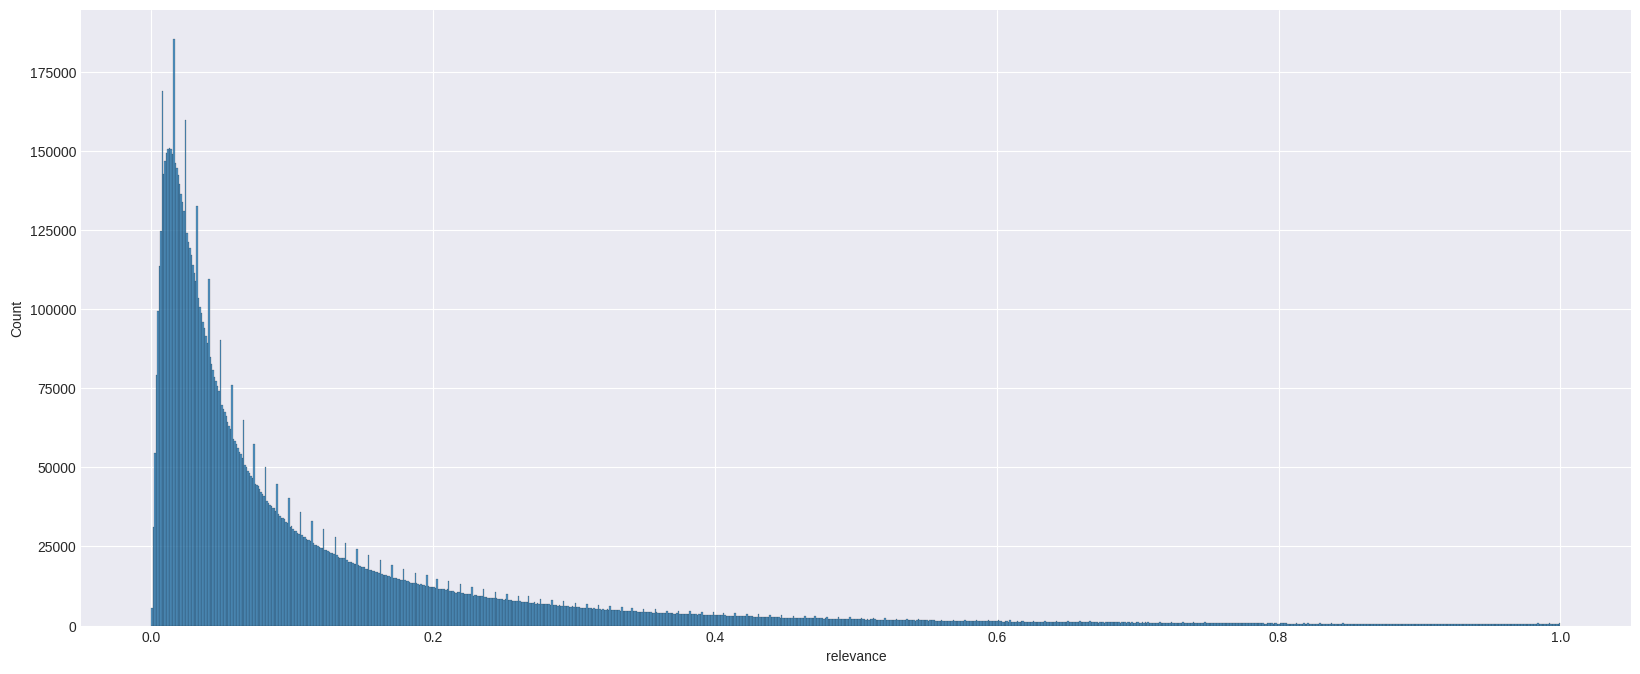

In [11]:
plt.figure(figsize=(20, 8))
sns.histplot(genome_scores_df.relevance)

Quais as tags mais importantes? Ou seja, com score alto entre os filmes

In [12]:
rel_by_tag = genome_scores_df.groupby('tagId').relevance.mean()
rel_by_tag

tagId
1       0.045935
2       0.045552
3       0.069405
4       0.085837
5       0.137502
          ...   
1124    0.091067
1125    0.041411
1126    0.045116
1127    0.111188
1128    0.030197
Name: relevance, Length: 1128, dtype: float64

Text(0.5, 1.0, 'Média das Relevâncias dos filmes agrupadas por Tag')

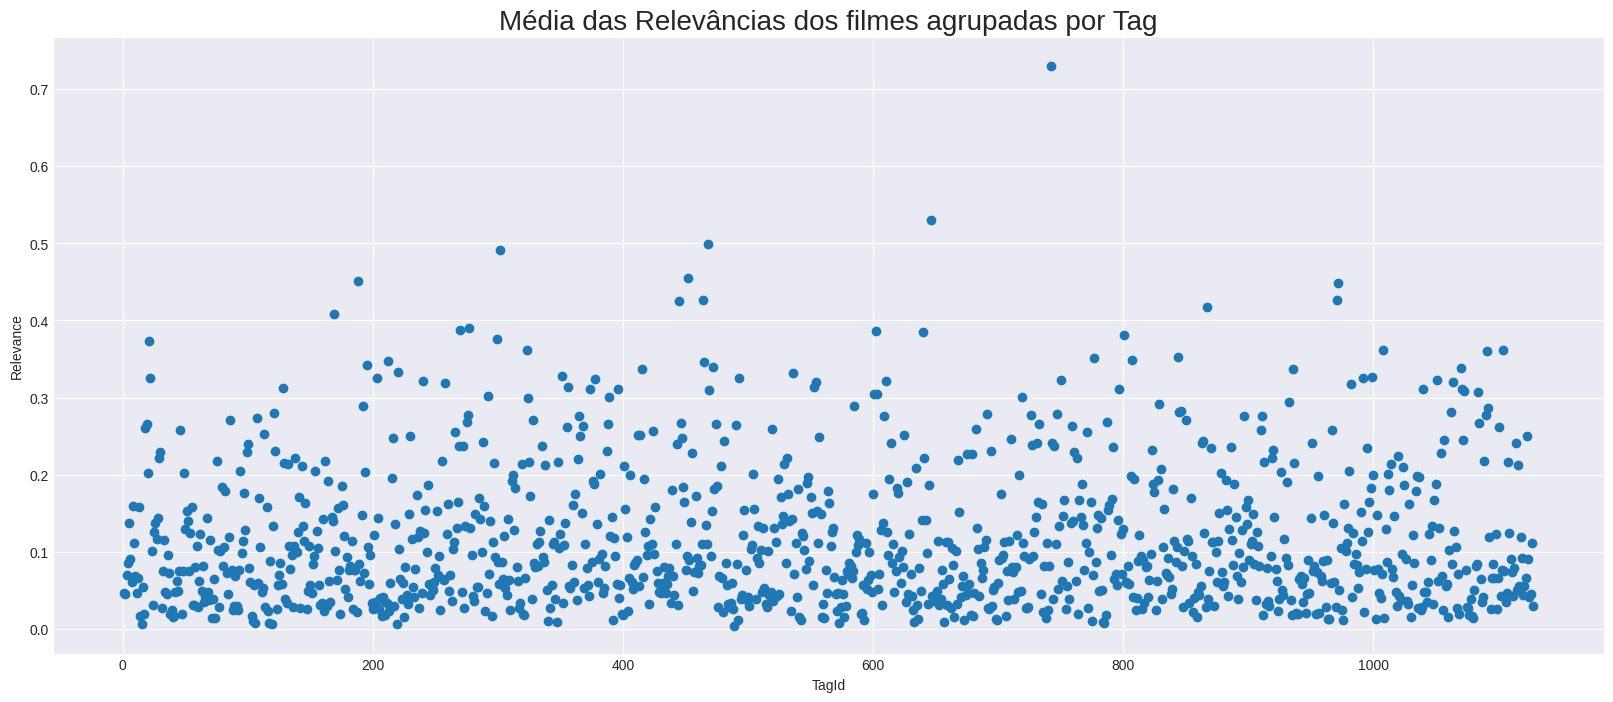

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(rel_by_tag.index, rel_by_tag.values, 'o')
plt.xlabel('TagId')
plt.ylabel('Relevance')
plt.title('Média das Relevâncias dos filmes agrupadas por Tag', fontsize=20)

In [14]:
indexes = rel_by_tag[rel_by_tag > 0.4].index
print(len(indexes))
rel_genome_scores = genome_scores_df.loc[genome_scores_df.tagId.isin(indexes)]
rel_genome_scores.head()

12


,movieId,tagId,relevance
168,1,169,0.20525
187,1,188,0.48600
301,1,302,0.63750
444,1,445,0.83550
451,1,452,0.73375


In [15]:
rel_genome_tags = rel_genome_scores.merge(genome_tags_df, on='tagId')
rel_genome_tags.head()

,movieId,tagId,relevance,tag
0,1,169,0.20525,brutality
1,2,169,0.22825,brutality
2,3,169,0.29950,brutality
3,4,169,0.31100,brutality
4,5,169,0.27050,brutality


The most relevant tag is Original in a movie.

In [16]:
tag_rel_mean = rel_genome_tags.groupby('tag').relevance.mean().reset_index()
tag_rel_mean.sort_values(by='relevance', ascending=False)

,tag,relevance
8,original,0.730527
7,mentor,0.530233
6,great ending,0.499534
2,dialogue,0.490878
4,good soundtrack,0.455614
1,catastrophe,0.450997
11,storytelling,0.448479
10,story,0.427058
5,great,0.426717
3,good,0.424800


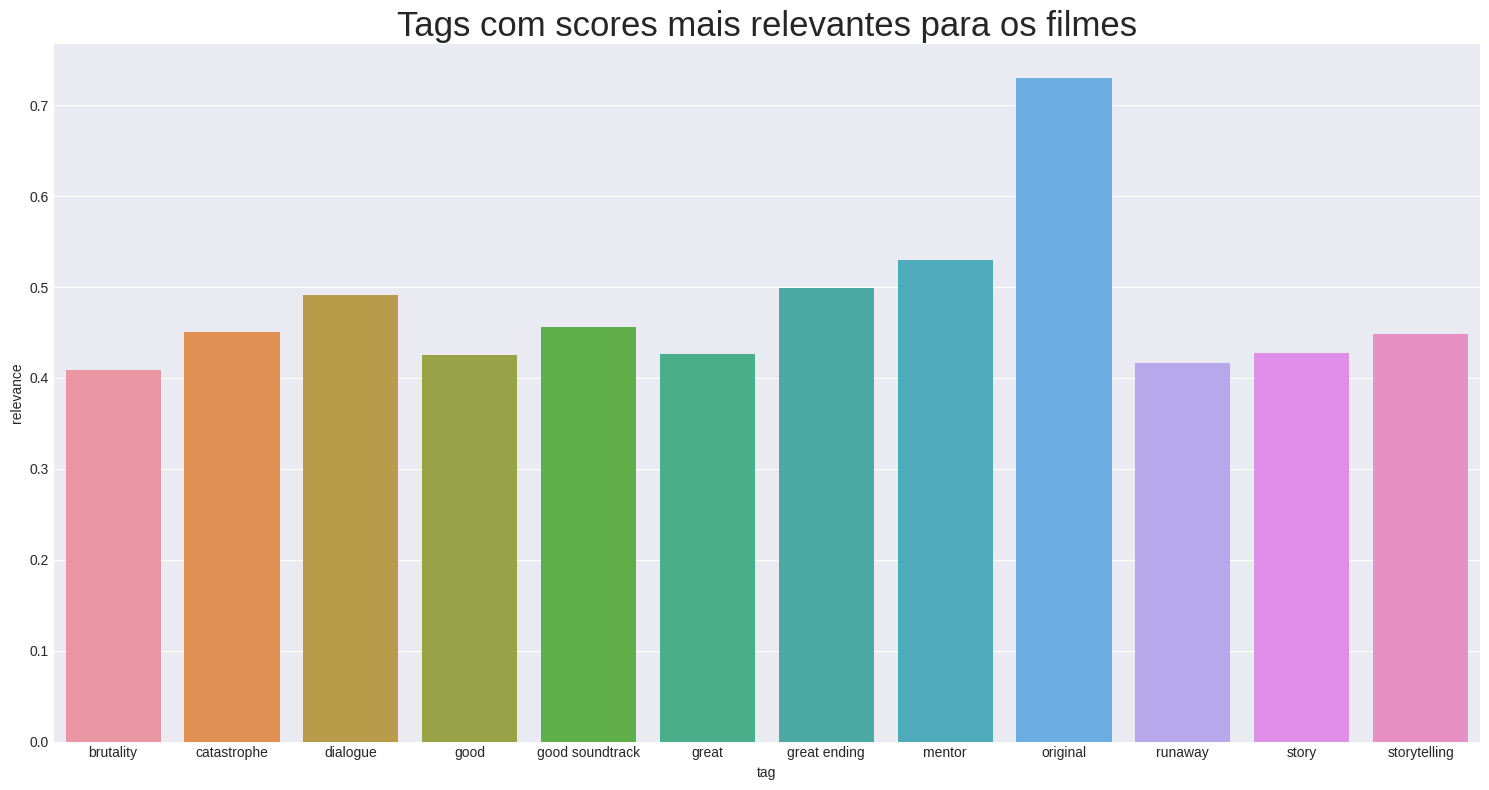

In [17]:
plt.figure(figsize=(15, 8))
sns.barplot(x='tag', y='relevance', data=tag_rel_mean)
plt.title("Tags com scores mais relevantes para os filmes", fontsize=25)
plt.tight_layout()
plt.savefig("tags_relevance.png", dpi=200)
plt.show()

# 3. ratings

Each line of this file after the header row represents one rating of one movie by one user. Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

In [18]:
rating_df = pd.read_csv(data_dir + 'rating.csv')
rating_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [19]:
rating_df.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [20]:
len(rating_df)

20000263

In [21]:
rating_df.rating.value_counts()

4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64

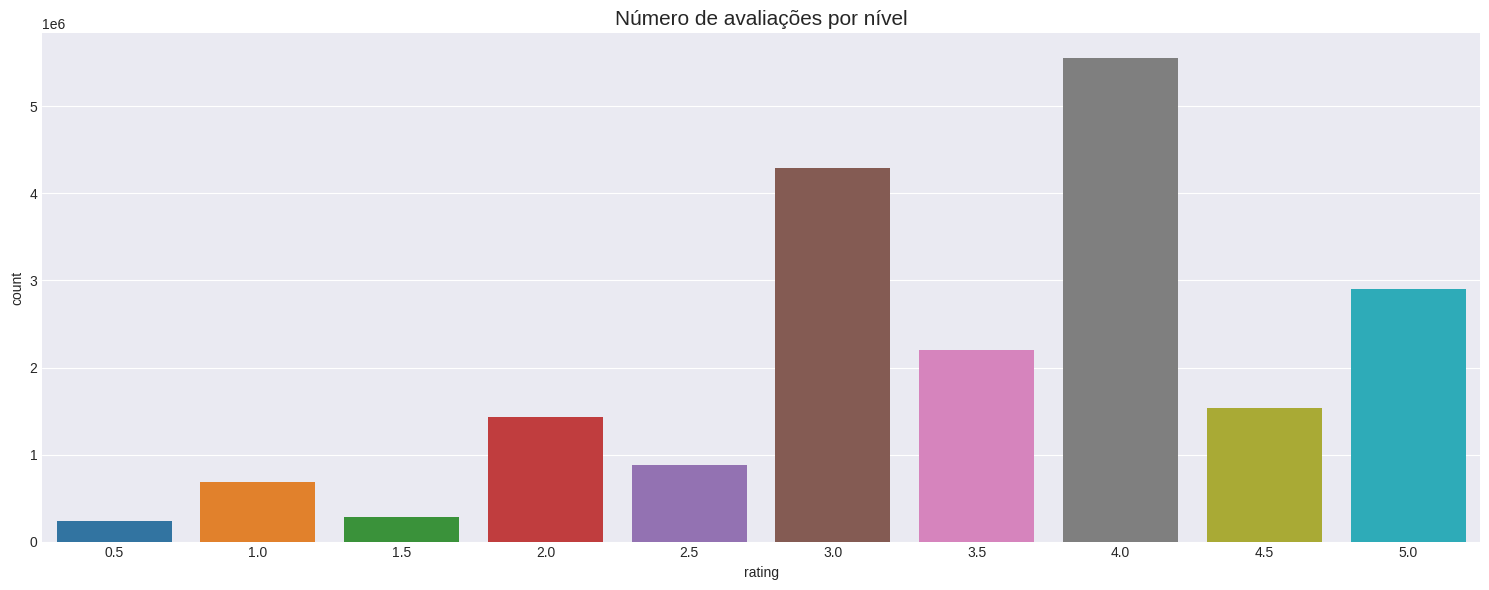

In [22]:
sns.countplot(x='rating', data=rating_df)
plt.title("Número de avaliações por nível", fontsize=15)
plt.tight_layout()
plt.savefig("rating.png", dpi=200)

# 4. movies

Only movies with at least one rating or tag are included in the dataset. These movie ids are consistent with those used on the MovieLens web site (e.g., id 1 corresponds to the URL https://movielens.org/movies/1).

In [23]:
movies_df = pd.read_csv(data_dir + 'movie.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [24]:
movies_df.describe()

,movieId
count,27278.000000
mean,59855.480570
std,44429.314697
min,1.000000
25%,6931.250000
50%,68068.000000
75%,100293.250000
max,131262.000000


Checking missing values

In [25]:
movies_df[movies_df.movieId.isnull()]

,movieId,title,genres


In [26]:
movies_df[movies_df.title.isnull()]

,movieId,title,genres


Standardizing the genres, removing stopwords, blankspaces etc

In [27]:
movies_df.genres = movies_df.genres.apply(lambda x: x.replace('|',' ').replace(')','').replace('(','').replace('-',''))
movies_df.genres = movies_df.genres.apply(lambda x: x.replace('no genres listed', 'unknown'))
movies_df.genres = movies_df.genres.apply(lambda x: x.strip().lower())

In [28]:
movies_df.genres

0        adventure animation children comedy fantasy
1                         adventure children fantasy
2                                     comedy romance
3                               comedy drama romance
4                                             comedy
                            ...                     
27273                                         comedy
27274                                         comedy
27275                                      adventure
27276                                        unknown
27277                       adventure fantasy horror
Name: genres, Length: 27278, dtype: object

In [29]:
genres_str = ''
# iterate through the csv file
for val in movies_df['genres']:
    
    # typecaste each val to string
    val = str(val)
    print(val)

    # split the value
    tokens = val.split()
    
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    genres_str += " ".join(tokens)+" "

adventure animation children comedy fantasy
adventure children fantasy
comedy romance
comedy drama romance
comedy
action crime thriller
comedy romance
adventure children
action
action adventure thriller
comedy drama romance
comedy horror
adventure animation children
drama
action adventure romance
crime drama
drama romance
comedy
comedy
action comedy crime drama thriller
comedy crime thriller
crime drama horror mystery thriller
action crime thriller
drama scifi
drama romance
drama
children drama
drama romance
adventure drama fantasy mystery scifi
crime drama
drama
mystery scifi thriller
adventure romance imax
children drama
drama romance
crime drama
documentary imax
children comedy
comedy romance
drama
drama war
action crime drama
drama
action adventure fantasy
comedy drama thriller
drama romance
mystery thriller
animation children drama musical romance
drama romance
crime mystery thriller
action drama thriller
comedy drama romance
adventure drama
children comedy
drama
adventure childre

In [30]:
genres = genres_str.strip().split(' ')
# replace('|',' ').replace(')','').replace('(','').replace('-','').strip().split(' ')
genres = np.unique(np.asarray(genres))
genres.shape[0]

20

In [31]:
genres_wc = ' '.join(map(str, genres))

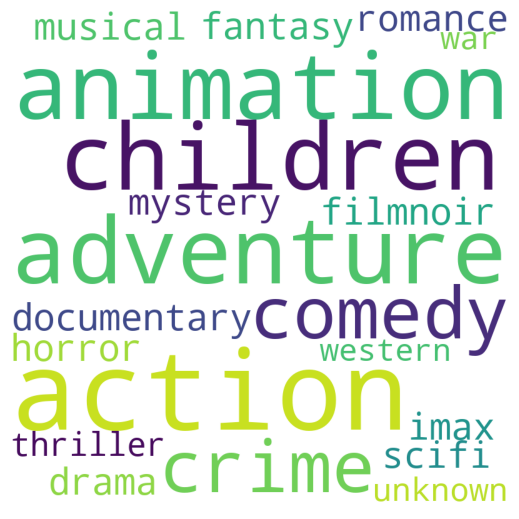

In [32]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                # stopwords = stopwords,
                min_font_size = 10).generate(genres_wc)

# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [33]:
for genre in genres:
    movies_df[genre] = 0

In [34]:
# one hot enconding dos gêneros
for genre in genres:
    movies_df.loc[movies_df.genres.apply(lambda x: genre in x), [genre]] = 1

In [35]:
movies_df.drop(columns='genres', inplace=True)

In [36]:
movies_df.head()

,movieId,title,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,filmnoir,horror,imax,musical,mystery,romance,scifi,thriller,unknown,war,western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
movies_df.to_csv('../data/processed/movie.csv',index=False)

In [38]:
counts = movies_df.iloc[:, 2:].sum().reset_index()
counts.columns = ['genre', 'count']
counts = counts.sort_values(by='count', ascending=False)
counts

,genre,count
7,drama,13344
4,comedy,8374
16,thriller,4178
14,romance,4127
0,action,3520
5,crime,2939
10,horror,2611
6,documentary,2471
1,adventure,2329
15,scifi,1743


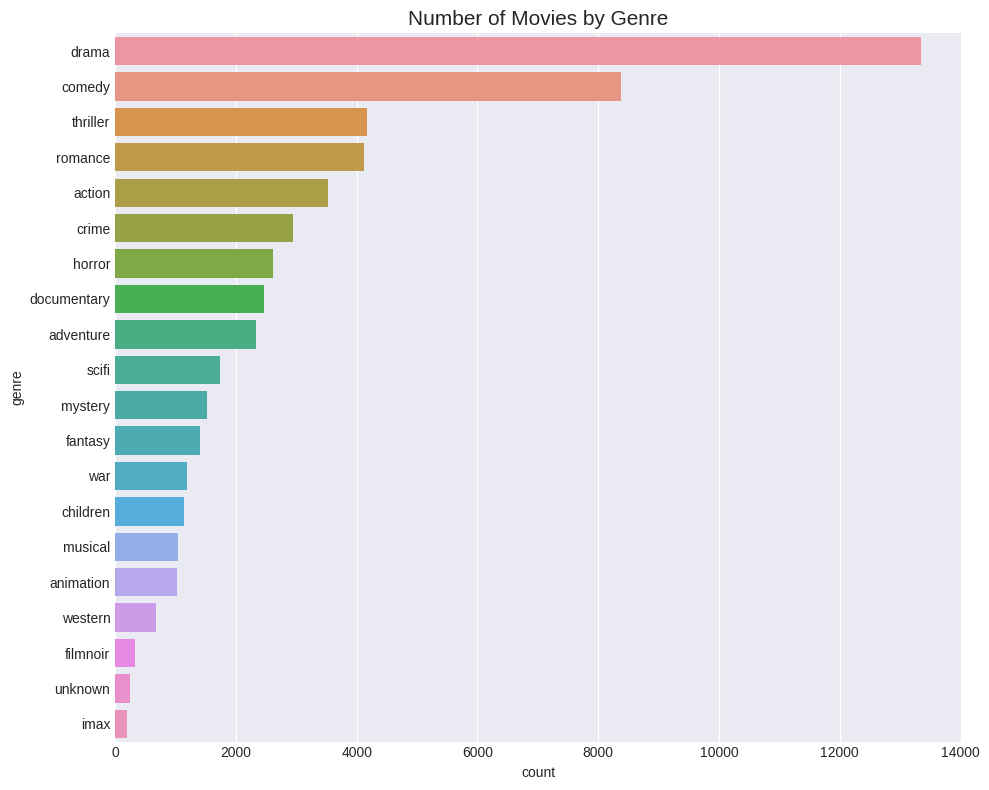

In [39]:
plt.figure(figsize=(10, 8))
sns.barplot(x='count', y='genre', data=counts)
plt.title('Number of Movies by Genre', fontsize=15)
plt.tight_layout()
plt.savefig("genres.png", dpi=200)
plt.show()

# 5. link

Identifiers that can be used to link to other sources of movie data

In [40]:
link_df = pd.read_csv(data_dir + 'link.csv')
link_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [41]:
link_df[link_df.imdbId.isna()]

,movieId,imdbId,tmdbId


# Exploração dos Dados

Quais os filmes mais e menos avaliados, e sua relação com a nota?

In [42]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [43]:
# mean_ratings_movie = rating_df.groupby('movieId').rating.mean().reset_index()
# mean_ratings_movie.sort_values(by='rating', ascending=False).head()

In [44]:
cross_movie_rating = rating_df.iloc[:, :-1].merge(movies_df.iloc[:,:2], on='movieId')
cross_movie_rating.head()

,userId,movieId,rating,title
0,1,2,3.5,Jumanji (1995)
1,5,2,3.0,Jumanji (1995)
2,13,2,3.0,Jumanji (1995)
3,29,2,3.0,Jumanji (1995)
4,34,2,3.0,Jumanji (1995)


In [45]:
title_rating = cross_movie_rating.groupby(by=['title']).agg(
    Count = ('title', 'count'),
    Media = ('rating', 'mean'),
    Max = ('rating', 'max'),
    Min = ('rating', 'min'),
    Median = ('rating', 'median'),
)

In [46]:
title_rating.sort_values(['Count'], ascending=False ).head()

,Count,Media,Max,Min,Median
title,,,,,
Pulp Fiction (1994),67310,4.174231,5.0,0.5,4.5
Forrest Gump (1994),66172,4.029000,5.0,0.5,4.0
"Shawshank Redemption, The (1994)",63366,4.446990,5.0,0.5,5.0
"Silence of the Lambs, The (1991)",63299,4.177057,5.0,0.5,4.0
Jurassic Park (1993),59715,3.664741,5.0,0.5,4.0


In [47]:
title_rating.sort_values(['Median'], ascending=False ).head()

,Count,Media,Max,Min,Median
title,,,,,
The Beautiful Story (1992),1,5.0,5.0,5.0,5.0
B-Side (2013),1,5.0,5.0,5.0,5.0
Shock and Awe: The Story of Electricity (2011),1,5.0,5.0,5.0,5.0
"Pursuit of Unhappiness, The (Anleitung zum Unglücklichsein) (2012)",1,5.0,5.0,5.0,5.0
Stealing a Nation (2004),1,5.0,5.0,5.0,5.0


O que faremos nestes casos que tem apenas uma única avaliação do filme?

In [50]:
# Analise Qtd x Avaliacao

px.scatter(
    # Dados
    data_frame=title_rating,
    # Parametros
    x='Count', y='Media',
    # Titulo
    title='Média x Quantidade - Titulos',
    # Upgrade
    # marginal_y='rug', marginal_x='histogram'
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Count=%{x}<br>Media=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array([ 3, 24, 39, ...,  2,  1,  1]),
              'xaxis': 'x',
              'y': array([3.66666667, 2.83333333, 2.87179487, ..., 1.5       , 3.        ,
                          1.5       ]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Média x Quantidade - Titulos'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Count'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Media'}}}
})